In [1]:
import os 
import time 
import numpy as np 
import pandas as pd 

from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, Callback
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.metrics import Precision, Recall, F1Score
from keras._tf_keras.keras.optimizers import Adam , RMSprop, Nadam, SGD
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, InputLayer, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D, LayerNormalization, Activation, GRU, Attention
from keras._tf_keras.keras.regularizers import L1L2, L1, L2
from keras._tf_keras.keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


from model.CNN_LSTM.components.engineering import FeatureEngineering
from model.CNN_LSTM.components.dfmodify import DataframeModify 
from model.CNN_LSTM.components.dfcreation import DataframeCreate, DataframeSave
from model.CNN_LSTM.components.custom_keras_callbacks import CustomEarlyStopping

In [2]:
def preprocess_pipeline(timeseries_columns: list, numerical_columns: list, categorical_columns: list = None):
    ts_numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)), # might want to change this out back to the interpolatioon methods
        ('imputer2', SimpleImputer(strategy="mean")),
        ('scaler', MinMaxScaler()) # we should use minmax?
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ("normalize", MinMaxScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")), # technically this is wrong
        ("ohe", OneHotEncoder(sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('ts_num', ts_numerical_transformer, timeseries_columns),
            ('num', numerical_transformer, numerical_columns),
            # ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='passthrough',
        sparse_threshold=0,
        n_jobs=1
    )
 
    preprocessor.set_output(transform="pandas")
    
    return preprocessor

def create_graphs(history_dev_1, cm, class_labels):
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Test Set Evaluation')
    plt.ion()
    plt.show()

    # Extracting the history
    train_loss = history_dev_1.history['loss']
    val_loss = history_dev_1.history['val_loss']
    train_acc = history_dev_1.history['accuracy']
    val_acc = history_dev_1.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # Create a figure with two subplots (2 rows, 1 column)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot training and validation loss
    ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue')
    ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Plot training and validation accuracy
    ax2.plot(epochs, train_acc, label='Train Accuracy', color='tab:green')
    ax2.plot(epochs, val_acc, label='Validation Accuracy', color='tab:red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    # Adjust layout to prevent overlap
    fig.tight_layout()

    # Display the plots
    plt.show()

In [3]:
import gc
input_path = r"C:\Users\Gen3r\Documents\capstone\ml_model\data\data_3"
dataframe = DataframeCreate.create_dataframe_from_data(input_path=input_path)
X_train, y_train, X_val, y_val, X_test, y_test = DataframeCreate.split_dataset(df=dataframe, target_label='gesture', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

landmark_columns = [f"{col}" for col in dataframe.columns if col.startswith(("hx", "hy", "hz", "px", "py", "pz", "lx", "ly", "lz", "rx", "ry", "rz"))]
categorical_columns = ["gesture_index"]
numerical_columns = ["frame", "frame_rate", "frame_width", "frame_height"] + [f"{col}" for col in dataframe.columns if col.startswith("pose_visibility")]
# derived_features =  [f"{feat}_{col}" for feat in ["velocity", "acceleration", "jerk"] for col in landmark_columns if col.startswith(("lx", "ly", "lz", "rx", "ry", "rz"))]
time_series_columns = landmark_columns  # + derived_features   
# res = [item for item in landmark_columns if item.startswith(("r", "l"))]

# augmenting train data
X_train_augmented, y_train = DataframeModify.augment_model(X_train, y_train, noise_level=0.05, translation_vector=[0.6, -0.5, 0.05], rotation_angle=45)
X_train_combined = pd.concat([X_train, X_train_augmented], axis=0, ignore_index=True)

gc.collect()

X_train_augmented_2, y_train = DataframeModify.augment_model(X_train_combined, y_train, noise_level=0.04, translation_vector=[0.2, 0.65, -0.15], rotation_angle=15)
X_train_combined_2 = pd.concat([X_train_combined, X_train_augmented_2], axis=0, ignore_index=True)

gc.collect()

X_train_augmented_3, y_train = DataframeModify.augment_model(X_train_combined_2, y_train, noise_level=0.03, translation_vector=[-0.4, 0.3, 0.1], rotation_angle=30)
X_train_combined_3 = pd.concat([X_train_combined_2, X_train_augmented_3], axis=0, ignore_index=True)

gc.collect()

print("finish augmentation")

X_train_transformed, X_val_transformed, X_test_transformed = None, None, None
Flag = True

if os.path.exists("X_train_transformed.csv.gz") and Flag == True:
    print("loaded from drive")
    X_train_transformed = pd.read_csv("X_train_transformed.csv.gz", compression="gzip")
    X_val_transformed = pd.read_csv("X_val_transformed.csv.gz", compression="gzip")
    X_test_transformed = pd.read_csv("X_test_transformed.csv.gz", compression="gzip")
else:
    print("starting new calculations")
    preprocessor = preprocess_pipeline(time_series_columns, numerical_columns, categorical_columns)
    X_train_transformed = preprocessor.fit_transform(X_train_combined_3)
    X_val_transformed = preprocessor.transform(X_val)
    X_test_transformed = preprocessor.transform(X_test)
    # DataframeSave.save_dataframe(X_train_transformed, X_val_transformed, X_test_transformed)
    pd.DataFrame.to_csv(X_train_transformed, "X_train_transformed.csv.gz", index=False, compression="gzip")
    print("done")
    pd.DataFrame.to_csv(X_val_transformed, "X_val_transformed.csv.gz", index=False, compression="gzip")
    print("done")
    pd.DataFrame.to_csv(X_test_transformed, "X_test_transformed.csv.gz", index=False, compression="gzip")
    print("done")

print(X_train_transformed.shape, y_train.shape, X_val_transformed.shape, y_val.shape, X_test_transformed.shape, y_test.shape)

# Define sequence length
sequence_length = 30

X_train_sequences, y_train_sequences = DataframeModify.create_sequences_with_labels(X_train_transformed, y_train, sequence_length)
X_val_sequences, y_val_sequences = DataframeModify.create_sequences_with_labels(X_val_transformed, y_val, sequence_length)
X_test_sequences, y_test_sequences = DataframeModify.create_sequences_with_labels(X_test_transformed, y_test, sequence_length)

# Print shapes to verify
print(X_train_sequences.shape)
print(X_val_sequences.shape)
print(X_test_sequences.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

class_labels = np.unique(y_test_sequences.tolist())

# Convert labels to categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_sequences)
y_val_encoded = label_encoder.transform(y_val_sequences)
y_test_encoded = label_encoder.transform(y_test_sequences)

y_train_categorical = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
y_val_categorical = to_categorical(y_val_encoded, num_classes=len(label_encoder.classes_))
y_test_categorical = to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))

print(y_train_categorical.shape)
print(y_val_categorical.shape)
print(y_test_categorical.shape)

(55440, 1667) (55440, 1) (6930, 1667) (6930, 1) (6930, 1667) (6930, 1)
finish augmentation
loaded from drive
(443520, 1667) (443520, 1) (6930, 1667) (6930, 1) (6930, 1667) (6930, 1)
(14784, 30, 1666)
(231, 30, 1666)
(231, 30, 1666)
(443520, 1)
(6930, 1)
(6930, 1)
(14784, 11)
(231, 11)
(231, 11)


Epoch 1/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.1008 - loss: 2.9482 - val_accuracy: 0.0909 - val_loss: 2.5565 - learning_rate: 1.0000e-04
Epoch 2/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.1155 - loss: 2.7896 - val_accuracy: 0.2424 - val_loss: 2.2350 - learning_rate: 1.0000e-04
Epoch 3/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.1610 - loss: 2.5692 - val_accuracy: 0.2554 - val_loss: 2.0617 - learning_rate: 1.0000e-04
Epoch 4/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.1999 - loss: 2.4114 - val_accuracy: 0.2165 - val_loss: 1.9377 - learning_rate: 1.0000e-04
Epoch 5/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.2385 - loss: 2.2317 - val_accuracy: 0.3853 - val_loss: 1.9825 - learning_rate: 1.0000e-04
Epoch 6/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.2975 - loss: 2.0503 - val_accuracy: 0.3593 - val_loss: 1.7254 - learning_rate: 1.0000e-04
Epoch 7/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/ste

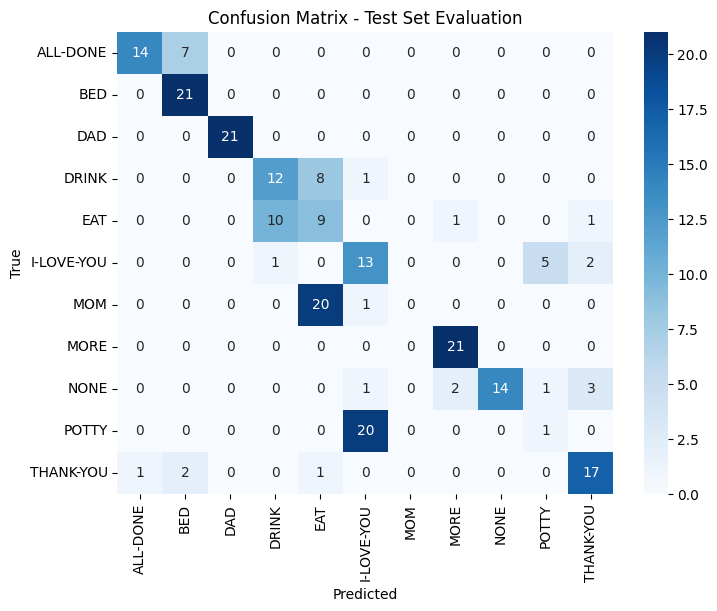

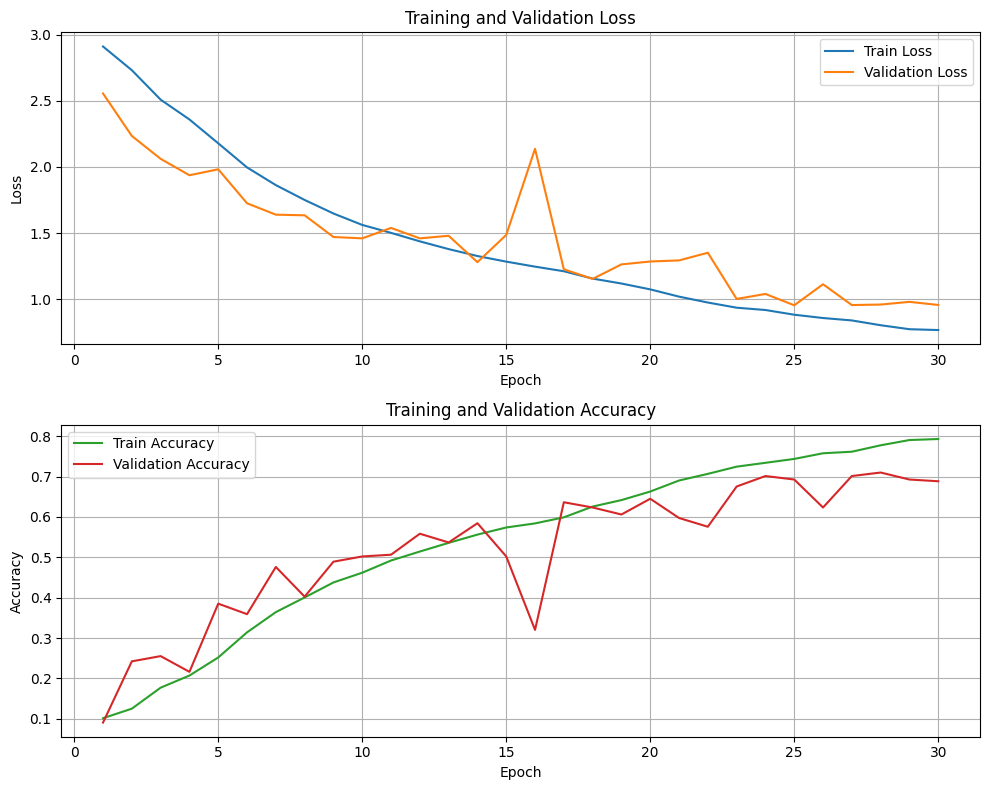

In [8]:
model = Sequential([
    # NOTE: if we where to just run this as is, we will get an error because of our Y datasets
    # They are a 2D shape, not the 1D it is expecting
    InputLayer(shape=(sequence_length, X_train_sequences.shape[2])),
    
    Conv1D(256, kernel_size=3),
    LayerNormalization(),
    Activation("relu"),
    MaxPooling1D(3),
    BatchNormalization(),
    Dropout(0.153),

    Conv1D(128, kernel_size=3),
    LayerNormalization(),
    Activation("relu"),
    MaxPooling1D(3),
    BatchNormalization(),
    Dropout(0.035),

    Bidirectional(GRU(128, return_sequences=True)),   
    LayerNormalization(),
    Activation("tanh"),
    BatchNormalization(),
    Dropout(0.135),

    Bidirectional(GRU(128, return_sequences=True)),   
    LayerNormalization(),
    Activation("tanh"),
    BatchNormalization(),
    Dropout(0.135),

    GlobalMaxPooling1D(),

    Dense(256, kernel_regularizer=L2(1e-4)),
    BatchNormalization(),
    Activation("leaky_relu"),
    Dropout(0.5),

    Dense(256, kernel_regularizer=L2(1e-4)),
    BatchNormalization(),
    Activation("tanh"),
    Dropout(0.55),

    Dense(128),
    BatchNormalization(),
    Activation("tanh"),
    Dropout(0.08),

    Dense(64, kernel_regularizer=L2(1e-3)),
    BatchNormalization(),
    Activation("tanh"),
    Dropout(0.2),
    
    Activation("tanh"),
    Dropout(0.5),
    Dense(len(class_labels), activation="softmax", kernel_regularizer=L2(1e-7))
])

model.compile(optimizer=Nadam(learning_rate=1.0e-4, weight_decay=1e-7, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-12)	
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)	
custom_early_stopping = CustomEarlyStopping(patience=6, threshold=0.15)
history = model.fit(
    X_train_sequences, y_train_categorical,
    validation_data=(X_val_sequences, y_val_categorical),
    epochs=50,  # Adjust epochs as needed
    batch_size=32,  # Adjust batch size as needed
    callbacks=[early_stopping, reduce_lr, custom_early_stopping]   
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_sequences, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

y_pred = model.predict(X_test_sequences)
y_test_labels = np.argmax(y_test_categorical, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)
create_graphs(history, cm, class_labels)

In [9]:
name = f"model_4quatre_v3_{time.time_ns()}"
model.save(f"{name}.keras")
model.save_weights(f"{name}.weights.h5")

In [32]:
from keras._tf_keras.keras.models import load_model

saved_model = load_model("models/model_1_v3.keras")
test_loss, test_accuracy = model.evaluate(X_test_sequences, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8085 - loss: 0.7691 
Test Loss: 0.8621662259101868
Test Accuracy: 0.7792207598686218


Trial 5 Complete [00h 09m 22s]
val_accuracy: 0.30519479513168335

Best val_accuracy So Far: 0.3246753364801407
Total elapsed time: 00h 48m 59s


c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 71 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 58s 333ms/step - accuracy: 0.3722 - loss: 2.1971 - val_accuracy: 0.2944 - val_loss: 2.3757 - learning_rate: 1.0000e-05
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 36s 307ms/step - accuracy: 0.3906 - loss: 2.1344 - val_accuracy: 0.2684 - val_loss: 2.2832 - learning_rate: 1.0000e-05
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 36s 314ms/step - accuracy: 0.3995 - loss: 2.0873 - val_accuracy: 0.2771 - val_loss: 2.3534 - learning_rate: 1.0000e-05
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 37s 317ms/step - accuracy: 0.4134 - loss: 2.0583 - val_accuracy: 0.2987 - val_loss: 2.2970 - learning_rate: 1.0000e-05
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 36s 313ms/step - accuracy: 0.4423 - loss: 2.0068 - val_accuracy: 0.2987 - val_loss: 2.3395 - learning_rate: 7.5000e-06
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.1828 - loss: 2.3924
Test Loss: 2.3098883628845215
Test Accuracy: 0.2554112672805786
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


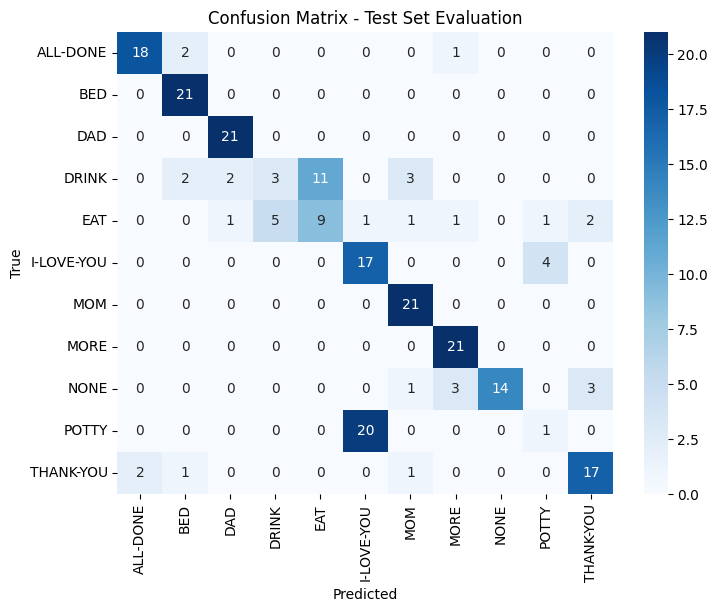

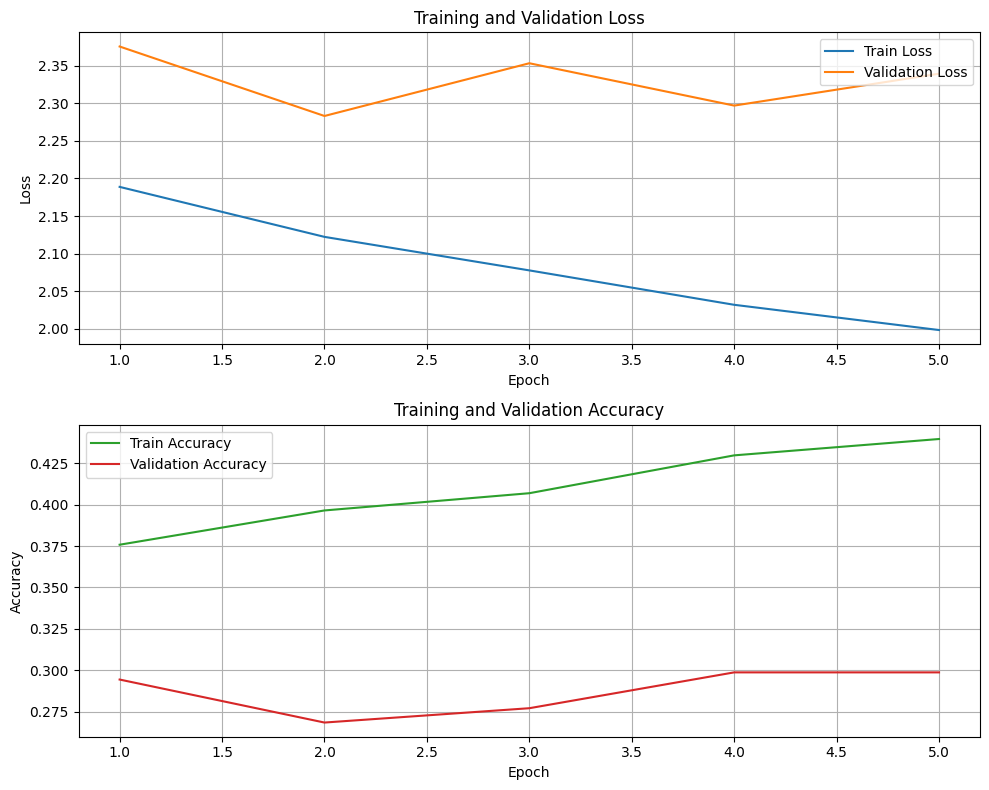

In [65]:
# keras tuner
import keras_tuner as kt 
from keras_tuner.tuners import BayesianOptimization, Hyperband
activation_list = ["relu", "leaky_relu", "tanh", "relu6"]

def build_model(hp: kt.HyperParameters):
    use_regularizer_1 = hp.Boolean("use_regularizer_1")
    if use_regularizer_1:
        regularizer_1 = L1L2(hp.Float("l1_1", min_value=1e-6, max_value=1e-3, sampling="log"), hp.Float("l2_1", min_value=1e-6, max_value=1e-3, sampling="log"))
    else:
        regularizer_1 = None

    use_regularizer_4 = hp.Boolean("use_regularizer_4")
    if use_regularizer_4:
        regularizer_type = hp.Choice("regularizer_type", values=["L1L2", "L2"])
        if regularizer_type == "L1L2":
            regularizer_4 = L1L2(hp.Float("l1_4", min_value=1e-6, max_value=1e-3, sampling="log"), hp.Float("l2_4", min_value=1e-6, max_value=1e-3, sampling="log"))
        else:
            regularizer_4 = L2( hp.Float("l2_4_2", min_value=1e-6, max_value=1e-3, sampling="log"))
    else:
        regularizer_4 = None

    model = Sequential([
        # NOTE: if we where to just run this as is, we will get an error because of our Y datasets
        # They are a 2D shape, not the 1D it is expecting
        InputLayer(shape=(sequence_length, 1666)),
        
        Conv1D(filters=hp.Int("units_1", min_value=1, max_value=512), kernel_size= hp.Int("k_size_1", 1, 3), activation=hp.Choice("activation_1", activation_list),
           kernel_regularizer=regularizer_1),
        Activation(activation=hp.Choice("activation_1", activation_list)),
        BatchNormalization(),
        MaxPooling1D(pool_size=hp.Int("p_size_1", min_value=1, max_value=2)),
        Dropout(hp.Float("drop_1", min_value=0.01, max_value=0.9)),

        Conv1D(filters=hp.Int("units_2", min_value=1, max_value=512), kernel_size=hp.Int("k_size_2", 1, 3), activation=hp.Choice("activation_2", activation_list)),
        LayerNormalization(),
        Activation(activation=hp.Choice("activation_2", activation_list)),
        MaxPooling1D(pool_size=hp.Int("p_size_2", min_value=1, max_value=2)),
        BatchNormalization(),

        Conv1D(filters=hp.Int("units_3", min_value=1, max_value=512), kernel_size=hp.Int("k_size_4", 1, 3)),
        Activation(activation=hp.Choice("activation_3", activation_list)),
        MaxPooling1D(pool_size=hp.Int("p_size_3", min_value=1, max_value=2)),

        Bidirectional(GRU(units=hp.Int("units7", min_value=24, max_value=512, step=32), return_sequences=True, kernel_regularizer=regularizer_4)),
        LayerNormalization(),
        Activation(activation=hp.Choice("activation_4", activation_list)),
        Dropout(hp.Float("drop_4", min_value=0.01, max_value=0.9)),
        
        GlobalMaxPooling1D(),
        
        Dense(hp.Int("units_5", min_value=1, max_value=1024), kernel_regularizer=L2(hp.Float("l2_5", min_value=1e-6, max_value=1e-3, sampling="log"))),
        BatchNormalization(),
        Activation(activation=hp.Choice("activation_5", activation_list)),
        Dropout(hp.Float("drop_5", min_value=0.01, max_value=0.9)),

        Dense(hp.Int("units_6", min_value=1, max_value=1024), kernel_regularizer=L2(hp.Float("l2_6", min_value=1e-6, max_value=1e-3, sampling="log"))),
        BatchNormalization(),

        Dense(hp.Int("units_7", min_value=12, max_value=1024), kernel_regularizer=L2(hp.Float("l2_7", min_value=1e-6, max_value=1e-3, sampling="log"))),
        BatchNormalization(),
        Activation(activation=hp.Choice("activation_7", activation_list)),
        Dropout(hp.Float("drop_7", min_value=0.01, max_value=0.9)),

        Activation(activation=hp.Choice("activation_8", activation_list)),
        Dropout(hp.Float("drop_8", min_value=0.01, max_value=0.9)),
        Dense(len(class_labels), activation='softmax', kernel_regularizer=L2(hp.Float("l2_8", min_value=1e-6, max_value=1e-3, sampling="log")))
    ])

    model.compile(optimizer=Nadam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5]), weight_decay=1e-7, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

tuner = BayesianOptimization(
    hypermodel=build_model,  # Your model-building function
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory="results_dir",
    project_name="cnn_rnn",
    overwrite=True,
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-12)	
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)	
custom_early_stopping = CustomEarlyStopping(patience=5, threshold=0.15)
tuner.search(X_train_sequences, y_train_categorical, epochs=25, validation_data=(X_val_sequences, y_val_categorical), callbacks=[early_stopping, reduce_lr, custom_early_stopping], batch_size=64)
best_model = tuner.get_best_models()[0]

history = best_model.fit(
    X_train_sequences, y_train_categorical,
    validation_data=(X_val_sequences, y_val_categorical),
    epochs=50,  # Adjust epochs as needed
    batch_size=64,  # Adjust batch size as needed
    callbacks=[early_stopping, reduce_lr, custom_early_stopping]   
)

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test_sequences, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

y_pred = model.predict(X_test_sequences)
y_test_labels = np.argmax(y_test_categorical, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)
create_graphs(history, cm, class_labels)